# Text Analytics Lab 4: Neural Network Classifiers

This notebook is introduces a new library, Pytorch, which we use to construct simple neural networks for processing text. 

NLP pipelines perform a series of steps to preprocess and then extract features from a piece of text, before inputting these features to a final classifier, sequence labeller, or other output stage. Neural networks allow us to reduce the amount of feature engineering needed in the pipeline, by learning to extract features in the hidden layers. 

Like logistic regression, they are disciminative models: they learn the classification task directly, without learning to generate the text. However, unlike logistic regression, they can model nonlinear functions of their inputs. This is achieved by having hidden layers with nonlinear activation functions. 

Some key advantages of neural networks can be summarised as:
   * It can model nonlinear functions, so can handle much more complex relationships between features and class labels.
   * It performs representation learning: the hidden layers learn how to extract features from low-level data.
   * It can process sequences of tokens -- we don't have to think in terms of a single feature vector representing a document as we did for logistic regression.

On the other hand, the downsides are:
   * Much more expensive to train and test.
   * It can overfit very badly to small datasets.
   * The features learned by the hidden layers can be hard to interpret, which can make it hard to predict the model's behaviour, e.g., what sort of cases it may fail on.
   * Generalisation is unpredictable: they sometimes behave in unexpected ways when applied to test data outside the training set distribution. 

## Learning Outcomes

These sections will contain tutorial-like instructions, as you have seen in previous text analytics labs. On completing these sections, you should be able to...
1. Recognise the steps required to train and test a neural text classifier with Pytorch
1. Modify the architecture of a neural text classifier by adding new hidden layers and changing hyperparameters.

# 1. Load a Dataset

First, we will load the [TweetEval sentiment dataset](https://huggingface.co/datasets/tweet_eval). This is a dataset for classifying Twitter posts into (0) negative, (1) neutral or (2) positive. 

In [1]:
import numpy as np
import torch
from datasets import load_dataset
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import word2vec
from gensim.utils import tokenize
import gensim.downloader
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
cache_dir = "./data_cache"

dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    cache_dir=cache_dir,
)

train_dataset = dataset["train"]
dev_dataset = dataset["validation"]
test_dataset = dataset["test"]

print(f"Training dataset with {len(train_dataset)} instances loaded")
print(f"Development/validation dataset with {len(dev_dataset)} instances loaded")
print(f"Test dataset with {len(test_dataset)} instances loaded")

Training dataset with 45615 instances loaded
Development/validation dataset with 2000 instances loaded
Test dataset with 12284 instances loaded


# 2. Introducing Neural Text Classifiers

This section shows you how to implement a neural network classifier using Pytorch and leads you through the steps required to process text sequences. Pytorch is an open source machine learning library that implements multi-dimensional arrays (called "tensors") and various mathematical operations on those arrays that are need for many machine learning methods. It supports GPU acceleration and is one of two major frameworks used in deep learning (the other is Tensorflow). 

Let's start by building a neural network text classifier that takes a sequence of tokens as input, and predicts a class label. For simplicity, it will use a single fully connected feedforward layer. 


We are going to construct the neural network in this form:

<img src="neural_text_classifier_smaller.png" alt="Neural text classifier diagram" width="600px"/>

The first step -- as always -- is to get our data into the right format. 
   1. We start by tokenising the raw text data so that each document (in this case, each tweet) is represented as a sequence of text tokens.
   2. The neural network cannot process the tokens as strings, so we need to convert each token to a numerical input value. We can create a vocabulary of token types, then convert each token to its index in the vocabulary. Elsewhere, you may have seen tokens represented by one-hot vectors. For PyTorch, it's not necessary to create one-hot vectors for each token, as the library works with the indexes of tokens directly.  
   3. In the embedding layer, the indexes of tokens are used to look up the corresponding word embedding from a matrix containing all embeddings.

So, let's now implement these steps. We start by tokenising the text using the Gensim tokeniser. We can make use of the "map()" function provided by the Dataset class to apply tokenisation to all samples in the dataset:

In [3]:
def tok_text(sample):
    sample["tokens"] = list(tokenize(sample['text']))
    return sample

tok_train_dataset = train_dataset.map(tok_text)

tok_train_dataset

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 45615
})

Next, we can build our vocabulary of token types using the Dictionary class:

In [4]:
from gensim.corpora import Dictionary

dictionary = Dictionary(tok_train_dataset["tokens"]) # construct word<->id mappings - it does it in alphabetical order
print(dictionary)

Dictionary<53730 unique tokens: ['Battle', 'HappyBirthdayRemusLupin', 'Hogwarts', 'In', 'Lupin']...>


We can look up the ID of a token -- its index in the vocabulary -- using the dictionary object as shown in the cell below. However, we need to reserve the value 0 for a special padding token, so we add one to all the indexes to get their "input_id" that we will pass into the neural network:

In [5]:
dictionary.token2id['a'] + 1  # get input_id for the token "a"

55

**TO-DO 1:** Write a function that maps a sample from tok_train_dataset from a list of tokens to a list of token IDs. Don't forget to add one to the indexes, as in the cell above. Save the list of token IDs into the sample dictionary as 'input_ids'. Then, use the ``map()`` method to apply this to the whole training set.

In [6]:
# WRITE YOUR CODE HERE

# tokenize training set and convert to input IDs.
def encode_text(sample):
   
    input_ids = []
    for token in sample["tokens"]:
        if token in dictionary.token2id:  # Skip words that are not in the vocabulary.
            input_ids.append(dictionary.token2id[token] + 1) 
            
    sample['input_ids'] = input_ids 
    return sample

# The map method of the dataset object takes a function as its argument, 
# and applies that function to each document in the dataset.
pre_train_dataset = tok_train_dataset.map(encode_text)
len(pre_train_dataset)  # length of preprocessed training dataset

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

45615

Our neural network's input layer has a fixed size, so our input sequences need to all have the same size. This means that all of our documents must have the same number of tokens. Let's plot a histogram to understand the length distribution of the texts in the training set:

Mean of the document length: 19.684752822536446
Median of the document length: 20.0
Maximum document length: 46


(array([5.0000e+01, 1.3000e+03, 6.5510e+03, 1.0287e+04, 1.6098e+04,
        8.6200e+03, 2.5290e+03, 1.6100e+02, 1.8000e+01, 1.0000e+00]),
 array([ 1. ,  5.5, 10. , 14.5, 19. , 23.5, 28. , 32.5, 37. , 41.5, 46. ]),
 <BarContainer object of 10 artists>)

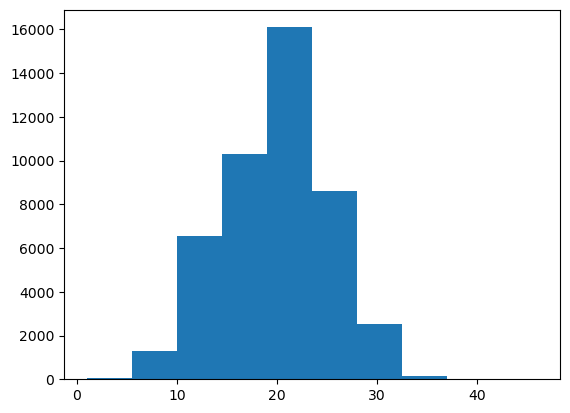

In [7]:
rv_l = [len(doc) for doc in pre_train_dataset['input_ids']]
print('Mean of the document length: {}'.format(np.mean(rv_l)))
print('Median of the document length: {}'.format(np.median(rv_l)))
print('Maximum document length: {}'.format(np.max(rv_l)))

plt.hist(rv_l)

We now neeed to choose a fixed sequence length, then *pad* the documents that are shorter than this maximum by adding a special token to the start of the sequence. The special pad token has an input value of 0. Any documents that exceed the length will be truncated.

**TO-DO 2:** Complete the padding code below to insert 0s at the start of any sequences that are too short, and to truncate any sequences that are too long.

In [8]:
sequence_length = 30  # truncate all docs longer than this. Pad all docs shorter than this.

def pad_text(sample):
    ###WRITE YOUR OWN CODE HERE

    if len(sample['input_ids']) >= sequence_length:
        sample['input_ids'] = sample['input_ids'][:sequence_length]
    else:
        sample['input_ids'] = [0]*(sequence_length-len(sample['input_ids'])) + sample['input_ids']
    ##########
    return sample

# The map method will call pad_text for every document in the dataset
pad_train_dataset = pre_train_dataset.map(pad_text)

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

We now have our data in almost the right format! To train a model using PyTorch, we are going to wrap our dataset in a [DataLoader object](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). This allows the training process to select random subsets of the dataset -- mini-batches -- which it will use for learning with mini-batch stochastic gradient descent.

In [9]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

# convert from the Huggingface format to a TensorDataset so we can use the mini-batch sampling functionality
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    tensor_dataset = TensorDataset(input_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

num_classes = len(np.unique(pad_train_dataset["label"]))   # number of possible labels 

train_loader = convert_to_data_loader(pad_train_dataset, num_classes)

In [10]:
num_classes

3

Let's preprocess the development and test set as well. We need the dev set when training our network to the model's fit, and to assess its performance with different hyperparameter settings. We use the test set to evaluate the final model on data that was not seen during its development to provide a fairer assessment of the model's generalisation. 

In [11]:
pre_dev_dataset = dev_dataset.map(tok_text).map(encode_text)
pad_dev_dataset = pre_dev_dataset.map(pad_text)
dev_loader = convert_to_data_loader(pad_dev_dataset, num_classes)

pre_test_dataset = test_dataset.map(tok_text).map(encode_text)
pad_test_dataset = pre_test_dataset.map(pad_text)
test_loader = convert_to_data_loader(pad_test_dataset, num_classes)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

As shown in the diagram above, we will build a NN with three different layers for sentiment classification.

### Embedding layer
In the embedding layer, the network will create its own embeddings for the index with a given embedding dimension.
The module `nn.Embedding()` creates a simple lookup table that stores embeddings of a fixed dictionary and size.
This module is often used to store word embeddings and retrieve them using indices.
The module's input is a list of indices, and the output is the corresponding word embeddings.

[Documentation for Embedding Class](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

### Fully-connected layer
Fully-connected layers in a neural network are those layers where all the inputs from the previous layer are connected to every unit of the fully-connected layer. Here we will use fully-connected layers for the hidden layer and output layer. In Pytorch this kind of layer is implemented by combining the 'Linear' class with a nonlinear activation function:

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

## Activation functions
In Pytorch, the activation function is not included in the Linear class (or other kinds of neural network layer), so we need to explicitly connect each layer to an activation function.
In Pytorch, we construct a neural network by connecting up the output of each component to the input of the next, thereby creating a computation graph.
To complete the hidden layer, we connect the ouput of the linear layer to a ReLU activation function, thereby creating a nonlinear function.

The cell below defines a class for our neural text classifier. The constructor creates each of the layers and the activations. The dimensions of each layer need to be correct so that the output of one layer can be passed as input to the next, but the code is not yet complete.

Below the constructor is the forward method. This is called in the 'forward pass' to map the neural network's inputs to its outputs. In PyTorch, we pass data through each layer of the model, connecting them together, then returning the output of the final layer.

**TO-DO 3:** Complete the constructor and the forward method below for a NN with three layers. The places where you need to add code are marked in the cell below. Refer to the Pytorch documentation for additional help.

In [12]:
from torch import nn

class FFTextClassifier(nn.Module):
    
    def __init__(self, vocab_size, sequence_length, embedding_size, hidden_size, num_classes):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_size

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding(vocab_size, embedding_size) # embedding layer
        
        ### COMPLETE THE CODE HERE: WRITE IN THE MISSING ARGUMENTS SPECIFYING THE DIMENSIONS OF EACH LAYER
        self.hidden_layer = nn.Linear(embedding_size*sequence_length, hidden_size) # Fully connected hidden layer
        self.activation = nn.ReLU() # Hidden layer
        ##########
        
        self.output_layer = nn.Linear(hidden_size, num_classes) # Fully connected output layer

        
        
    def forward (self, input_words):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)

        # flatten the sequence of embedding vectors for each document into a single vector.
        embedded_words = embedded_words.reshape(embedded_words.shape[0], sequence_length*self.embedding_size)  # batch_size, seq_length*embedding_size

        z = self.hidden_layer(embedded_words)   # (batch_size, hidden_size)
        
        ### ADD THE MISSING LINE HERE
        h = self.activation(z)                  # (batch_size, hidden_size)
        ########

        output = self.output_layer(h)                      # (batch_size, num_classes)

        # Notice we haven't applied a softmax activation to the output layer -- it's not required by Pytorch's loss function.

        return output

Now the class is complete. 

**TO-DO 4:** In the next cell, create a NN with the FFTextClassifier class we wrote.

Hint: `model = FFTextClassifier(...)`

In [13]:
vocab_size = len(dictionary) + 1  # add one for the padding tokens
embedding_size = 25  # number of dimensions for embeddings
hidden_size = 16 # number of hidden units

###WRITE YOUR OWN CODE HERE
ff_classifier_model = FFTextClassifier(vocab_size, sequence_length, embedding_size, hidden_size, num_classes)

After desigining our network, we need to create a training function to calculate the loss for each input and perform backpropagation to optimise the network.
During training, the weights of all the layers will be updated.

Below, we build a training function to train the NN over a fixed number of epochs (an epoch is one iteration over the whole training dataset).
The function also prints the performance of both training and development/validation set after each epoch.

Here we use cross-entropy loss, which is the standard loss function for classification that we also used for logistic regression. The module `nn.CrossEntropyLoss()` operates directly on the output of our output layer, so we don't have to implement the softmax layer within the forward() method.

Cross Entropy Loss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

The optimizer object implements a particular algorithm for updating the weights. Here, we will use the Adam optimizer, which is a variant of stochastic gradient descent method that tends to find a better solution in a smaller number of iterations than standard SGD.

Optimization: https://pytorch.org/docs/stable/optim.html

The cell below defines a training function for our classifier. 

**TO-DO 5:** First, try to follow what each line is doing. Then, modify the training function above to return the training and development (or 'validation') losses at each epoch.

In [14]:
from torch import optim

def train_nn(num_epochs, model, train_dataloader, dev_dataloader):
    
    learning_rate = 0.0005  # learning rate for the gradient descent optimizer, related to the step size

    loss_fn = nn.CrossEntropyLoss()  # create loss function object
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
    
    all_train_losses = []
    all_dev_losses = []
    
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct = 0
        total_trained = 0
        train_losses = []

        model.train()  # Put the model in training mode.

        for i, (batch_input_ids, batch_labels) in enumerate(train_dataloader):
            # Iterate over each batch of data
            # print(f'batch no. = {i}')

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            # This will run the forward() function.
            output = model(batch_input_ids)

            # Compute the loss for the current batch of data
            batch_loss = loss_fn(output, batch_labels)

            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Record the loss from this sample to keep track of progress.
            train_losses.append(batch_loss.item())

            # Count correct labels so we can compute accuracy on the training set
            predicted_labels = output.argmax(1)
            total_correct += (predicted_labels == batch_labels).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct/total_trained*100

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))
        
        ### ANSWER CODE HERE
        all_train_losses.append(np.mean(train_losses))
        ###
        
        model.eval()  # Switch model to evaluation mode - turn off any random steps such as dropout
        total_correct = 0
        total_trained = 0
        dev_losses = []

        for dev_input_ids, dev_labels in dev_dataloader:
            ### ANSWER CODE HERE
            dev_output = model(dev_input_ids)
            dev_loss = loss_fn(dev_output, dev_labels)
            
            # Save the loss on the dev set
            dev_losses.append(dev_loss.item())
            #######
            
            # Count the number of correct predictions
            predicted_labels = dev_output.argmax(1)
            total_correct += (predicted_labels == dev_labels).sum().item()
            total_trained += dev_labels.size(0)
            
        dev_accuracy = total_correct/total_trained*100
        
        ### ANSWER CODE HERE
        all_dev_losses.append(np.mean(dev_losses))
        ###
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))

    ### ANSWER CODE HERE
    return model, all_train_losses, all_dev_losses

**TO-DO 6:**  Train the network for 15 epochs and plot the losses by completing the cell below. At which epoch did we get the best model fit? How could we use the dev set losses to return the best model? Remember that neural networks tend to overfit if trained too long, as they have many parameters and are very flexible. 

Note that the answer can vary each time you run the training process due to random initialisation of the model weights and shuffling of the dataset. 

ANSWER
   * The plot shows the best fit around 5 epochs before it starts to overfit, as the validation loss converges while training loss goes down 
   * If dev set loss stops going down for a long time, but training set loss keeps decreasing, the model may be overfitting.
   * We can stop training at the point where dev set loss stops decreasing 
   * Or we could save the model with best dev set performance and use that model to make predictions.

Epoch: 1/10 Training Loss: 1.0104 Training Accuracy: 45.5574%
Epoch: 1/10 Validation Loss: 1.0105 Validation Accuracy: 44.5000%
Epoch: 2/10 Training Loss: 0.9752 Training Accuracy: 50.6193%
Epoch: 2/10 Validation Loss: 0.9892 Validation Accuracy: 48.1500%
Epoch: 3/10 Training Loss: 0.9232 Training Accuracy: 55.4489%
Epoch: 3/10 Validation Loss: 0.9593 Validation Accuracy: 52.7000%
Epoch: 4/10 Training Loss: 0.8645 Training Accuracy: 59.3270%
Epoch: 4/10 Validation Loss: 0.9492 Validation Accuracy: 53.3000%
Epoch: 5/10 Training Loss: 0.8090 Training Accuracy: 62.9004%
Epoch: 5/10 Validation Loss: 0.9467 Validation Accuracy: 54.9000%
Epoch: 6/10 Training Loss: 0.7566 Training Accuracy: 65.8775%
Epoch: 6/10 Validation Loss: 0.9323 Validation Accuracy: 56.2000%
Epoch: 7/10 Training Loss: 0.7102 Training Accuracy: 68.6134%
Epoch: 7/10 Validation Loss: 0.9634 Validation Accuracy: 56.7000%
Epoch: 8/10 Training Loss: 0.6652 Training Accuracy: 71.0797%
Epoch: 8/10 Validation Loss: 0.9502 Valida

Text(0, 0.5, 'loss')

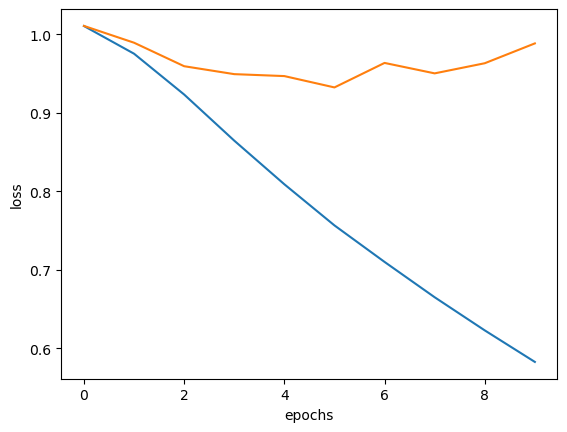

In [15]:
import matplotlib.pyplot as plt

num_epochs = 10

plt.figure()

###WRITE YOUR OWN CODE HERE

trained_model, train_losses, dev_losses = train_nn(num_epochs, ff_classifier_model, train_loader, dev_loader)
plt.plot(train_losses, label='train')
plt.plot(dev_losses, label='dev')

####

plt.xlabel('epochs')
plt.ylabel('loss')

The code below obtains predictions from our neural network:

In [16]:
def predict_nn(trained_model, test_loader):

    trained_model.eval()  # switch off some randomisation used during training (dropout) to give consistent predictions

    correct = 0  # count the number of correct classification labels

    gold_labs = []  # gold labels to return
    pred_labs = []  # predicted labels to return
    
    for inputs, labels in test_loader:
        test_output = trained_model(inputs)  # run the forward() function on the inputs
        predicted_labels = test_output.argmax(1)  # select the class labels with highest logits as our predictions

        gold_labs.extend(labels.tolist())
        pred_labs.extend(predicted_labels.tolist())
    
    return gold_labs, pred_labs

gold_labs, pred_labs = predict_nn(trained_model, test_loader)

Now, we can use pretrained word embeddings instead of learning them from scratch during training.
Here, we will use pretrained GloVe embeddings that were trained on Tweets, as the text domain is the same as our hate speech dataset. The embedding matrix is used to initialise the embedding layer. The code below converts the GloVe embeddings into an embedding matrix suitable for PyTorch:

In [17]:
import gensim.downloader

# download the word embeddings from Gensim
glove_wv = gensim.downloader.load('glove-twitter-25')

In [18]:
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))

glove_wv.vectors

count = 0

for word in glove_wv.index_to_key:
    if word in dictionary.token2id:
        word_idx = dictionary.token2id[word]
    
        embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])
        count +=1 
        
print(embedding_matrix)
print(count)

/var/folders/zs/mvzshj0d25jb097mcs64pfqc0000gp/T/ipykernel_12498/3602796992.py:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1704987090896/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.2062,  1.5804,  0.9181,  ...,  1.6417, -0.6852, -0.3649],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
21935


The class below extends the FFTextClassifier class to make use of the pretrained embeddings. This means that it inherits all of its functionality, but we overwrite the constructor (the `__init__` method). This way, we don't need to define the forward function again, as it will be the same as before.

The embedding layer is now different as it loads pretrained embeddings from our matrix. The argument `freeze` determines whether the embeddings remain fixed to their pretrained values (if `freeze=True`) or are updated through backpropagation to fit them to the dataset.

In [19]:
class FFTextClassifierWithEmbeddings(FFTextClassifier):

    def __init__(self, hidden_size, sequence_length, num_classes, embedding_matrix):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_matrix.shape[1] 

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) # embedding layer

        ### COMPLETE THE ARGUMENTS TO SPECIFY THE DIMENSIONS OF THE LAYERS
        self.hidden_layer = nn.Linear(self.embedding_size*sequence_length, hidden_size) # Hidden layer
        self.activation = nn.ReLU() # Hidden layer
        self.output_layer = nn.Linear(hidden_size, num_classes) # Full connection layer

**TO-DO 7:** Complete the arguments in the `FFTextClassifierWithEmbeddings` constructor to set the dimensions of the neural network layers.  Repeat the experiment above using the FFTextClassifierWithEmbeddings with the GLoVe embeddings and compare the performance of the two neural text classifiers. 

Note that freezing the pretrained embeddings will speed up the training process, but may make the model less accurate.

In [45]:
### COMPLETE THE CODE BELOW
ff_emb_model = FFTextClassifierWithEmbeddings(hidden_size, sequence_length, num_classes, embedding_matrix)
trained_emb_model, _, _ = train_nn(5, ff_emb_model, train_loader, dev_loader)
gold_labs_emb, pred_labs_emb = predict_nn(trained_emb_model, test_loader)

Epoch: 1/5 Training Loss: 0.6122 Training Accuracy: 75.4905%
Epoch: 1/5 Validation Loss: 0.8684 Validation Accuracy: 63.2000%
Epoch: 2/5 Training Loss: 0.3130 Training Accuracy: 89.1593%
Epoch: 2/5 Validation Loss: 1.0154 Validation Accuracy: 63.5000%
Epoch: 3/5 Training Loss: 0.2437 Training Accuracy: 91.6782%
Epoch: 3/5 Validation Loss: 1.1527 Validation Accuracy: 63.3000%
Epoch: 4/5 Training Loss: 0.2041 Training Accuracy: 93.0133%
Epoch: 4/5 Validation Loss: 1.2372 Validation Accuracy: 62.7500%
Epoch: 5/5 Training Loss: 0.1748 Training Accuracy: 94.0480%
Epoch: 5/5 Validation Loss: 1.3651 Validation Accuracy: 62.2000%


In [46]:
from sklearn.metrics import f1_score

# Evaluate the models using F1 score
print(f'Random embedding intialisation: {f1_score(gold_labs, pred_labs, average="macro")}')
print(f'Frozen pretrained GloVe embeddings: {f1_score(gold_labs_emb, pred_labs_emb, average="macro")}')

# note that gold_labs_emb and gold_labs are different -- the dataset gets shuffled each time we iterate using the data loader. 

Random embedding intialisation: 0.31191399472264625
Frozen pretrained GloVe embeddings: 0.5234137272507644


The model we have tried so far uses fully-connected layers, which means that the weights applied to a particular word's embedding are specific to the location of the word in the sentence -- shifting the tokens along by one could produce a completely different result. We could improve this by using a recurrent neural network layer, that processes the tokens sequentially. The code below adapts our class to use a bidirectional LSTM for the hidden layer(s).

**TO-DO 8:** Complete the constructor and forward method below and test the class with the LSTM layer.

In [40]:
class LSTMTextClassifierWithEmbeddings(FFTextClassifier):

    def __init__(self, hidden_size, sequence_length, num_classes, embedding_matrix):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_matrix.shape[1] 

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.hidden_layer = nn.LSTM(self.embedding_size, hidden_size, bidirectional=True, batch_first=True)
        
        ### COMPLETE THE ARGUMENTS TO SPECIFY THE DIMENSIONS OF THE LAYERS
        self.activation = nn.ReLU() # Hidden layer
        self.output_layer = nn.Linear(2*hidden_size, num_classes) # Full connection layer

    def forward (self, input_words):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)

        # flatten the sequence of embedding vectors for each document into a single vector.
        # embedded_words = embedded_words.reshape(embedded_words.shape[0], sequence_length*self.embedding_size)  # batch_size, seq_length*embedding_size
        _, (z, _) = self.hidden_layer(embedded_words)   # (2, batch_size, hidden_size)
        z = z.swapaxes(0, 1).flatten(1)
        
        ### ADD THE MISSING LINE HERE
        h = self.activation(z)                  # (batch_size, 2*hidden_size)
        ########
        
        output = self.output_layer(h)                      # (batch_size, num_classes)

        # Notice we haven't applied a softmax activation to the output layer -- it's not required by Pytorch's loss function.

        return output

# WRITE YOUR CODE HERE TO TEST THE LSTM CLASSIFIER
lstm_emb_model = LSTMTextClassifierWithEmbeddings(hidden_size, sequence_length, num_classes, embedding_matrix)
trained_emb_model, _, _ = train_nn(5, lstm_emb_model, train_loader, dev_loader)
gold_labs, pred_labs_lstm = predict_nn(trained_emb_model, test_loader)

Epoch: 1/5 Training Loss: 1.0054 Training Accuracy: 46.6820%
Epoch: 1/5 Validation Loss: 0.9734 Validation Accuracy: 50.1500%
Epoch: 2/5 Training Loss: 0.9036 Training Accuracy: 56.3389%
Epoch: 2/5 Validation Loss: 0.8824 Validation Accuracy: 57.7500%
Epoch: 3/5 Training Loss: 0.7799 Training Accuracy: 64.4240%
Epoch: 3/5 Validation Loss: 0.8296 Validation Accuracy: 62.5000%
Epoch: 4/5 Training Loss: 0.6785 Training Accuracy: 70.3825%
Epoch: 4/5 Validation Loss: 0.8072 Validation Accuracy: 63.8500%
Epoch: 5/5 Training Loss: 0.5915 Training Accuracy: 75.0016%
Epoch: 5/5 Validation Loss: 0.7978 Validation Accuracy: 64.1000%


In [41]:
from sklearn.metrics import f1_score
print(f'LSTM + Pretrained GloVe embeddings: {f1_score(gold_labs, pred_labs_lstm, average="macro")}')

LSTM + Pretrained GloVe embeddings: 0.5527904918864945


**TO-DO 9:** There are various ways that we could improve the classifier above. Consider what you could change, and try out two simple improvements. Think about the size and number of the hidden layers, the embedding dimensions, and monitoring dev losses to select the best training epoch. 